# M5 - Forecasting Uncertainty

## 1.Business Problem

### 1.1 Description

The Makridakis Open Forecasting Center (MOFC) at the University of Nicosia conducts cutting-edge forecasting research and provides business forecast training. The MOFC is well known for its Makridakis Competitions, the first of which ran in the 1980s.

In this competition,they asked the contestants to predict the uncertainty forecasts for the next 28 days for which we will use hierarchical sales data from Walmart, the world’s largest company by revenue.  
This specific competition is the first of its kind, opening up new directions for both academic research and how uncertainty could be assessed and used in organizations.

### 1.2 Problem Statement

Estimate the uncertainty distribution of Walmart unit sales.
In this challenge, we are predicting 9 quartiles of item sales at stores in various locations for two 28-day time periods of uncertainty forecasting with the corresponding median and 50%, 67%, 95%, and 99% prediction intervals (PIs).

The task in hand is to predict the uncertainty forecasting with the given unit sales of the data which covers stores in three US States (California, Texas, and Wisconsin) and also includes item level, department, product categories, and store details. In addition, it has explanatory variables such as price, promotions, day of the week, and special events. Together, this robust dataset can be used to improve forecasting accuracy.

It helps companies achieve accurate predictions, estimate the levels of uncertainty, avoiding costly mistakes, and apply best forecasting practices.

### 1.3 Sources/Useful Links
1. Kaggle - Competition : https://www.kaggle.com/c/m5-forecasting-uncertainty/overview
2. Solution approach : https://www.kaggle.com/robertburbidge/lightgbm-poisson-w-scaled-pinball-loss
3. A theory book on Forecasting Principles : https://otexts.com/fpp2/

### 1.4 Real world/Business Objectives and Constraints
1. The cost of a mis-classification can be high.
2. No strict latency concerns.
3. Interpretability of the model is important.

## 2. Machine Learning Problem

### 2.1 Type of Machine learning problem.

It is a Regression problem, given the past unit sales and predict the number of sales.
There are 12 levels starting the level 1 with the total number of sales in all states to level 12, individual product unit sales for a period of 28 days.

### 2.2 Evaluation metric

### 2.2.1 Scaled Pinball Loss (SPL)

Source: https://www.kaggle.com/c/m5-forecasting-uncertainty/overview/evaluation

The precision of the probabilistic forecasts will be evaluated using the Scaled Pinball Loss (SPL) function.
The measure is calculated for each series and quantile as follows:

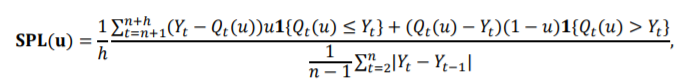


where 
𝑌𝑡 is the actual future value of the examined time series at point t,
𝑄𝑡(𝑢) the generated forecast for quantile u,
h the forecasting horizon, 
n the length of the training sample (number of historical observations),
and 1 the indicator function



### 2.2.2 Weighted Scaled Pinball Loss (WSPL)

 All hierarchical levels are equally weighted.This is because the total dollar sales of products is same in each of the 12 levels.

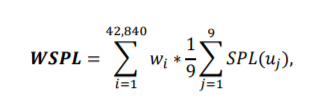

where
𝑤𝑖 is the weight of the 𝑖𝑡ℎ series of the competition,
𝑢𝑗 the 𝑗𝑡ℎ out of the examined quantiles

In the M5 competiton we have 12 aggregation levels and as all hierarchical levels are equally weighted the weights should be $w_{i}=\frac{1}{12}$. The total number of time series is higher than what is given in train as all levels up to the top aggregation are included.


## 3. Exploratory Data Analysis

### 3.1 Loading the data

Here we are loading the data of the given 4 csv files named Calendar, sales_train_validation,sell_prices and finally the sample_submission file.

In [106]:
import os
import math as m
import numpy as np                                 # linear algebra
import pandas as pd                                # dataframes
import matplotlib.pyplot as plt                    # visualizations
import seaborn as sns
import ipywidgets as widgets                       # interative jupyter
from IPython.display import clear_output

from scipy import stats                            # statistics
from dateutil.relativedelta import relativedelta

from matplotlib.patches import Polygon
import warnings
warnings.filterwarnings("default", category=DeprecationWarning)
import datetime
from dateutil.relativedelta import relativedelta
import re
import itertools
from datetime import timedelta
import warnings
warnings.simplefilter("ignore")


### 3.2 File Content 

A look at all columns and rows of all the loaded files.


### 3.2.1 Calendar 


In [107]:
calendar = pd.read_csv("../input/m5-forecasting-uncertainty/calendar.csv")
calendar['date']=pd.to_datetime(calendar['date'])
calendar

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0


* Calender has date features of weekday,month,year including wm_yr_wk which is a combination of week and year.
* The date starts from 01-29-2011 and ends on 19-06-2016 which tells that the data ranges for 5 years and 5 months.
* d feature shows all the days starting from d_1 to d_1969.
* There are certain special events and occassions with features names and types.
* It also has SNAP binary features per each state

### 3.2.2  Sales_train

In [108]:
sales_train = pd.read_csv("../input/m5-forecasting-uncertainty/sales_train_validation.csv")
sales_train

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,2,0,0,0,0,0,1,0,0,1
30486,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
30487,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,2,1,0,2,0,1,0,0,1,0
30488,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,1,0,0,1,0,3,1,3


* The sales data has columns for the ids of items(3049),departments(7),categories(3),stores(10) and states(3).
* The first column id is actually a combination of all the previously mentined ids and also added with a validation.
* The rest of the features are startingfrom d_1 to d_1913 which shows the number of units sold on that particular day(column) of a particular product(row).

### 3.2.3 Sell_prices

In [109]:
sell_prices = pd.read_csv("../input/m5-forecasting-uncertainty/sell_prices.csv")
sell_prices

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26
...,...,...,...,...
6841116,WI_3,FOODS_3_827,11617,1.00
6841117,WI_3,FOODS_3_827,11618,1.00
6841118,WI_3,FOODS_3_827,11619,1.00
6841119,WI_3,FOODS_3_827,11620,1.00


* The given data has prices for each product(sell_price) in a particular week of a year using id - wm_yr_wk of a particular store

### 3.2.4 Sample_submission

In [110]:
sample_submission = pd.read_csv('../input/m5-forecasting-uncertainty/sample_submission.csv')
sample_submission

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,Total_X_0.005_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CA_X_0.005_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,TX_X_0.005_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,WI_X_0.005_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CA_1_X_0.005_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
771115,FOODS_3_823_WI_3_0.995_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
771116,FOODS_3_824_WI_3_0.995_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
771117,FOODS_3_825_WI_3_0.995_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
771118,FOODS_3_826_WI_3_0.995_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


* There are F1 to F28 columns(28days) for which we find the uncertainty predictions.
* id feature has all the aggregate 12 levels along with uncertainty prediction interval and either validation or evaluation.
* The first half is for validation and the second half is for evaluation.
* The total number of these aggregate 12 levels are 42,840(from the competitions guide)and there are 9 uncertainty prediction intervals (0.005,0.025,0.165,0.25,0.5,0.75,0.835,0.975,0.995) and each of these for validation and evaluation, so over all 42840*9*2 = 771120 rows(ids)

### 3.3 Memory Reduction

In [111]:
# Helper function to reduce the memory usage for all the given data sets

def mem_usage_reduction(df, verbose=True):
    """
    reduces the mem usage by performing certain coercion operations
    inp: dataframe,
         verbose (whether to print the info regarding mem reduction or Not)
    returns: dataframe
    """
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb from {:5.2f} ({:.1f}% reduction)'.format(end_mem,start_mem, 100 * (start_mem - end_mem) / start_mem))
    return df



In [112]:
calendar = mem_usage_reduction(calendar, verbose = True)
sales_train = mem_usage_reduction(sales_train, verbose = True)
sell_prices = mem_usage_reduction(sell_prices, verbose = True)
sample_submission = mem_usage_reduction(sample_submission, verbose = True)

Mem. usage decreased to  0.12 Mb from  0.21 (41.9% reduction)
Mem. usage decreased to 95.00 Mb from 446.40 (78.7% reduction)
Mem. usage decreased to 130.48 Mb from 208.77 (37.5% reduction)
Mem. usage decreased to 26.47 Mb from 170.61 (84.5% reduction)


## 4. Visual Overview

### 4.1 Aggregation Of All States - Level 1

In [113]:
# separating only d_(day)columns from the sales_train data
day_columns = sales_train.columns[sales_train.columns.str.contains('d_')].values

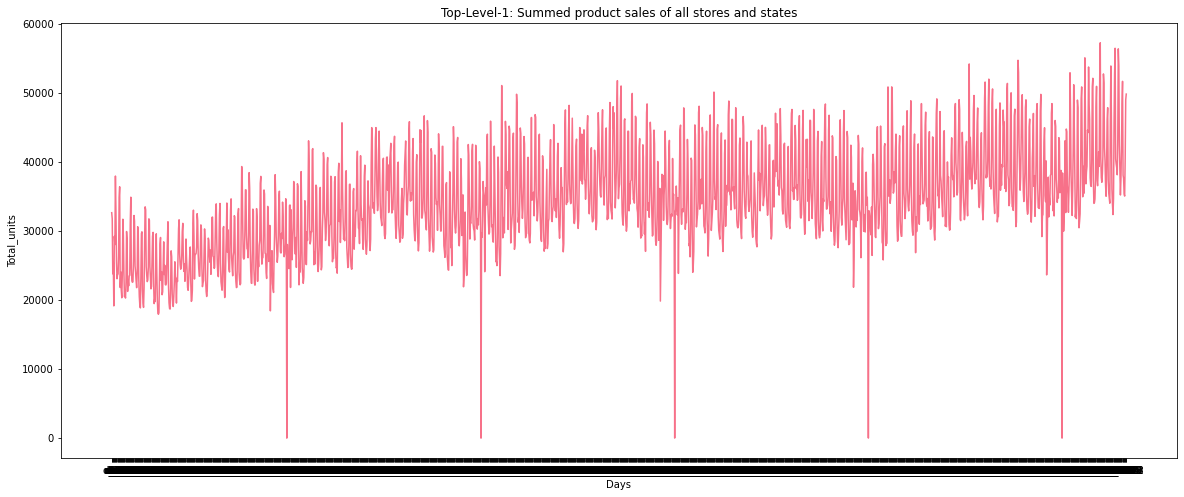

In [114]:
Total_sales = sales_train[day_columns].sum()
plt.figure(figsize=(20,8))
plt.plot(Total_sales)
plt.xlabel('Days')
plt.ylabel('Total_units')
plt.title("Top-Level-1: Summed product sales of all stores and states")
plt.show()

* This is the summed product sales total on each day for all the days.
* The plot is actually following a nice periodic pattern with over all increase in every year except for one sudden dip to 0 on christmas day as all stores are closed on that day.

In [115]:
del Total_sales

 ### 4.2 Aggregation Per State - Level 2

In [116]:
a = sales_train.groupby("state_id")[day_columns].sum().transpose()
new = 'd_'
day_lst = []
for i in range(1,1914):
    new_1 = new+str(i)
    day_lst.append(new_1)
a['day'] = day_lst

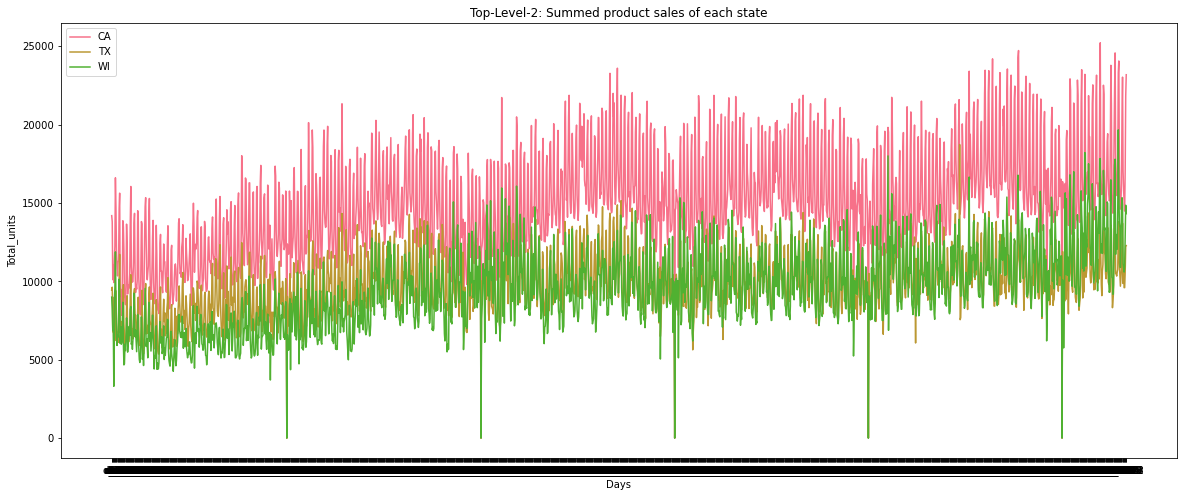

In [117]:
plt.figure(figsize=(20,8))
for i in range(0,3):
    plt.plot(a['day'],a.iloc[:,i:i+1])
plt.xlabel('Days')
plt.ylabel('Total_units')
plt.title("Top-Level-2: Summed product sales of each state")
plt.legend(['CA', 'TX','WI'])
plt.show()

* The total sales of CA is always higher than the rest of the two states.
* TX had an initial higher sales than WI but  they levelled up in the middle and WI crossed TX at the very end.
* All the sales show a nice periodic pattern

In [118]:
del a

 ### 4.3 Aggregation Per Store - Level 3

In [119]:
b = sales_train.groupby("store_id")[day_columns].sum().transpose()
b['day']=day_lst

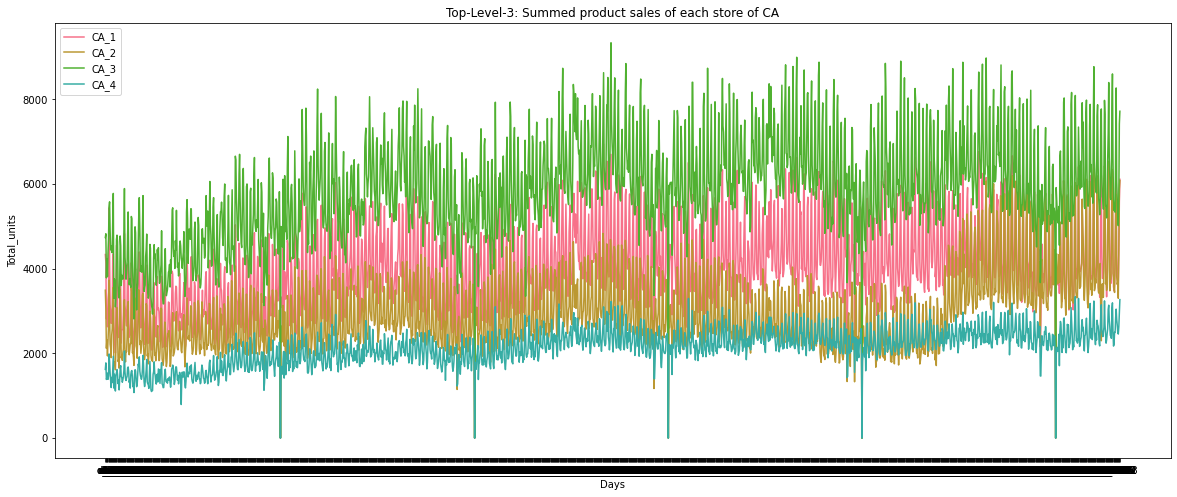

In [120]:
plt.figure(figsize=(20,8))
for i in range(0,4):
    plt.plot(b['day'],b.iloc[:,i:i+1])
plt.xlabel('Days')
plt.ylabel('Total_units')
plt.title("Top-Level-3: Summed product sales of each store of CA")
plt.legend(['CA_1', 'CA_2','CA_3','CA_4'])
plt.show()

* CA_3 is the highest of all the 4 stores.It has increased through the years.
* There is a sidden rise in CA2 after d_1600.
* The sales of CA_4 stayed almost the same all 4 years.


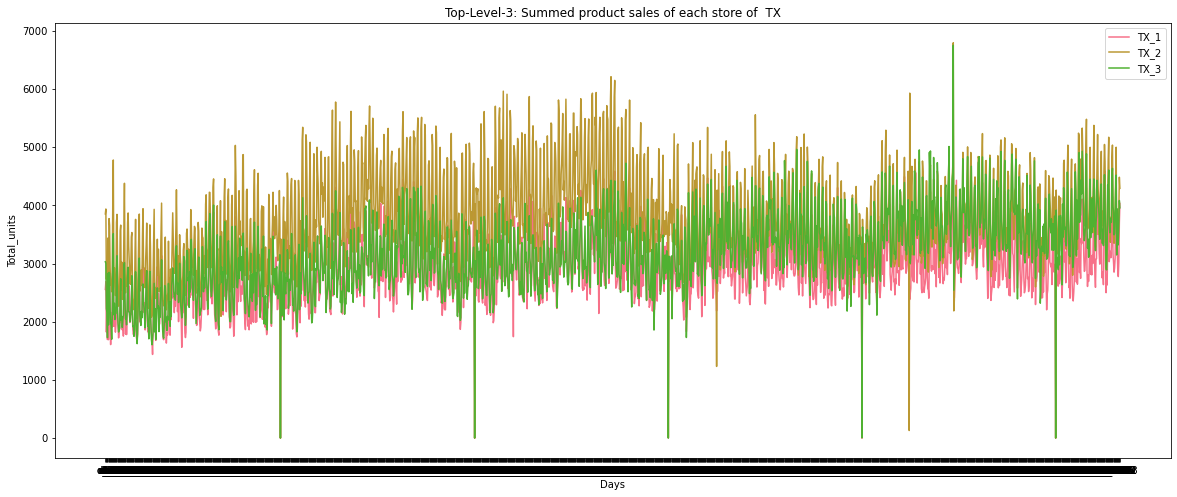

In [121]:
plt.figure(figsize=(20,8))
for i in range(4,7):
    plt.plot(b['day'],b.iloc[:,i:i+1])
plt.xlabel('Days')
plt.ylabel('Total_units')
plt.title("Top-Level-3: Summed product sales of each store of  TX")
plt.legend(['TX_1', 'TX_2','TX_3'])
plt.show()

* Plot has no much difference between TX_1 and TX_2. 
* TX_2 sales were high initially but then decreased as the years progress.

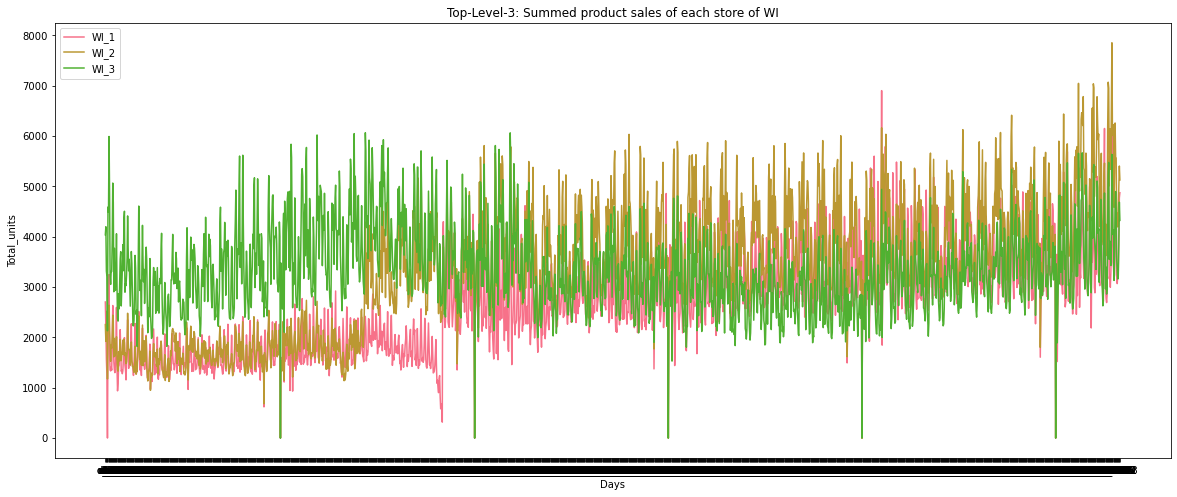

In [122]:
plt.figure(figsize=(20,8))
for i in range(7,10):
    plt.plot(b['day'],b.iloc[:,i:i+1])
plt.xlabel('Days')
plt.ylabel('Total_units')
plt.title("Top-Level-3: Summed product sales of each store of WI")
plt.legend(['WI_1', 'WI_2','WI_3'])
plt.show()

* WI_3 was highest initially and then both WI_1 and WI2 met with WI_3 in the total sales.
* There is a sudden rise in WI_2  around d_500 and WI_1 around d_600.


In [123]:
del b

 ### 4.4 Aggregation Per Category - Level 4

In [124]:
c = sales_train.groupby("cat_id")[day_columns].sum().transpose()
c['day']=day_lst

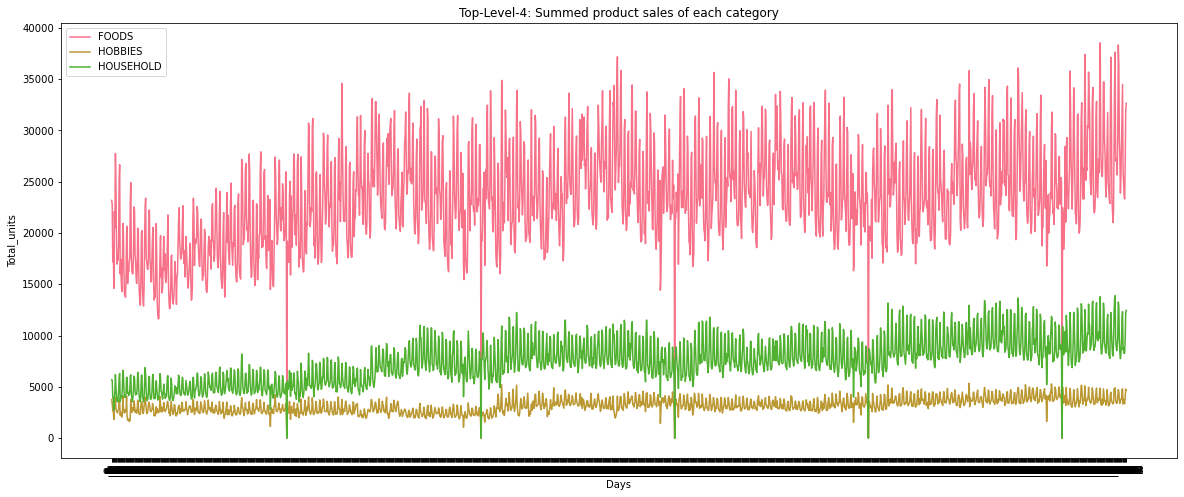

In [125]:
plt.figure(figsize=(20,8))
for i in range(0,3):
    plt.plot(c['day'],c.iloc[:,i:i+1])
plt.xlabel('Days')
plt.ylabel('Total_units')
plt.title("Top-Level-4: Summed product sales of each category")
plt.legend(['FOODS', 'HOBBIES','HOUSEHOLD'])
plt.show()

* All the three categories are well separated and FOODS being the highest sold category.
* All the categories follow a periodic increase through the years.

In [126]:
del c

 ### 4.5 Aggregation Per Department - Level 5

In [127]:
d = sales_train.groupby('dept_id')[day_columns].sum().transpose()
d['day']=day_lst

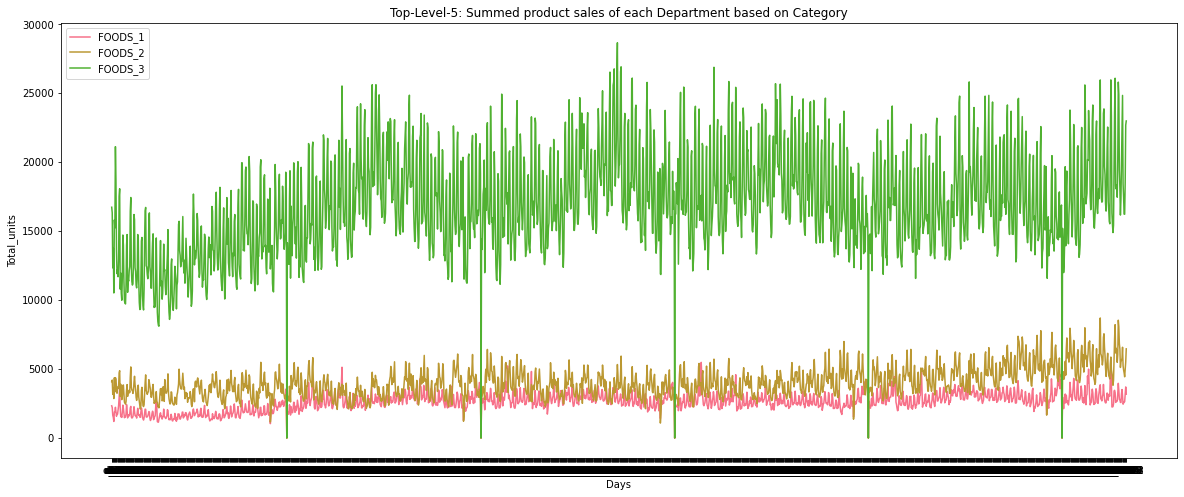

In [128]:
plt.figure(figsize=(20,8))
for i in range(0,3):
    plt.plot(d['day'],d.iloc[:,i:i+1])
plt.xlabel('Days')
plt.ylabel('Total_units')
plt.title("Top-Level-5: Summed product sales of each Department based on Category")
plt.legend(['FOODS_1', 'FOODS_2','FOODS_3'])
plt.show()

* All have a periodic pattern and all are well separated.
* FOODS_3 has too many sales compared to other departments.

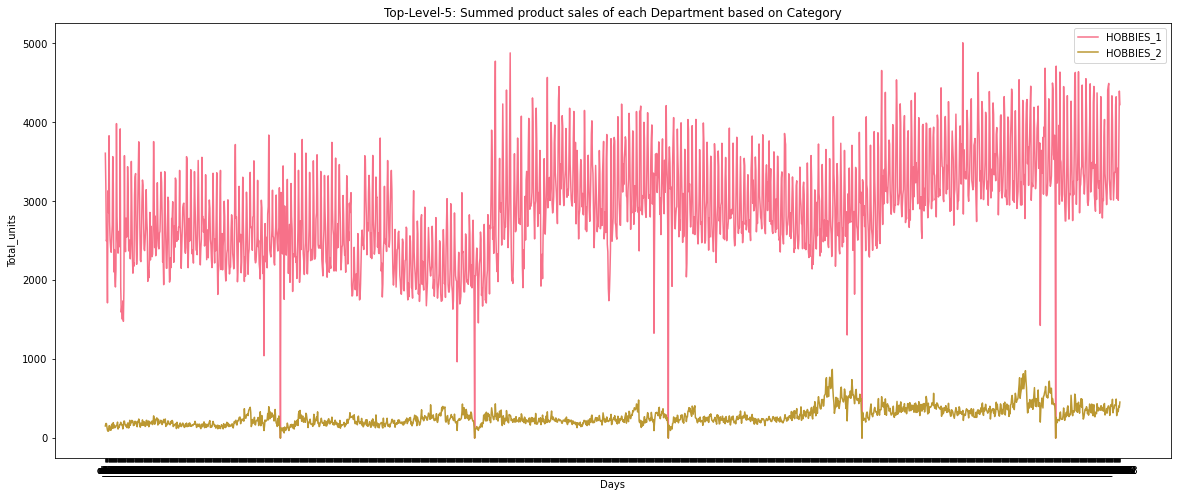

In [129]:
plt.figure(figsize=(20,8))
for i in range(3,5):
    plt.plot(d['day'],d.iloc[:,i:i+1])
    plt.xlabel('Days')
plt.ylabel('Total_units')
plt.title("Top-Level-5: Summed product sales of each Department based on Category")
plt.legend(['HOBBIES_1', 'HOBBIES_2'])
plt.show()

* Sales of HOBBIES_1 have a sudden rise after d_700 where as HOBBIES_2 stayed the same almost all the years.
* There is a huge variation between the sales of these two deparments.

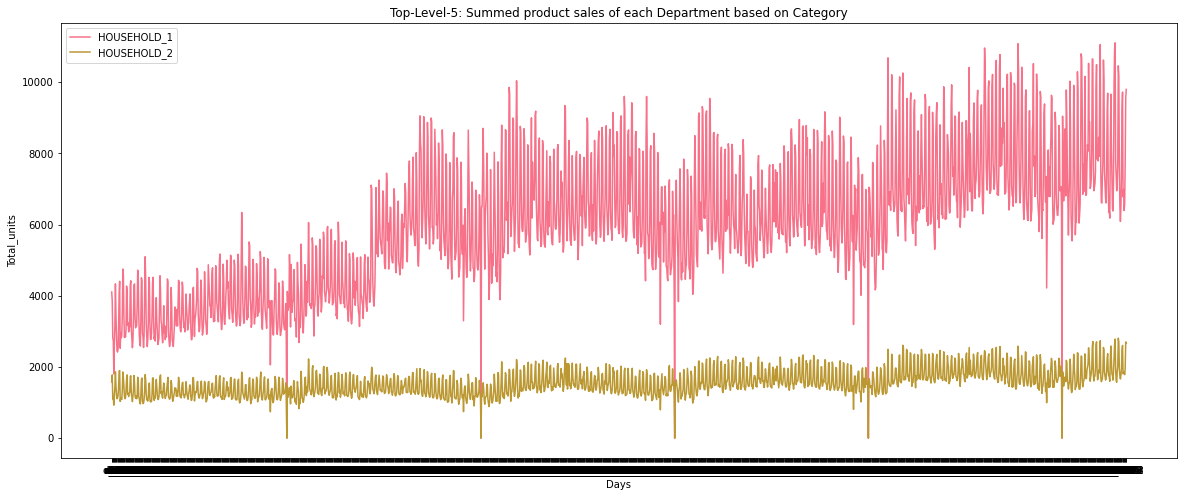

In [130]:
plt.figure(figsize=(20,8))
for i in range(5,7):
    plt.plot(d['day'],d.iloc[:,i:i+1])
plt.xlabel('Days')
plt.ylabel('Total_units')
plt.title("Top-Level-5: Summed product sales of each Department based on Category")
plt.legend(['HOUSEHOLD_1', 'HOUSEHOLD_2'])
plt.show()

* HOUSEHOLD_1 has drastically increased its sales.
* HOUSEHOLD_2  stayed same the whole time and there is a huge difference between these two deparments.

In [131]:
del d

### 4.6 Melting the dataframe

The given dataframe is wide which has 1913 day features for all the products.We are converting it to long data frame.

In [132]:
day_value_var = [col for col in sales_train.columns if col.startswith("d_")] # separating day features
identifier_var = [col for col in sales_train.columns if col not in day_value_var] 

# converting the df from wide to long
sales_train_df = pd.melt(sales_train,id_vars = identifier_var,value_vars = day_value_var)


# changing the variable and value column names to convinient names
sales_train_df = sales_train_df.rename(columns = {"variable": "day_no.", "value": "unit_sales"})
print(sales_train_df.shape)
sales_train_df.head()

(58327370, 8)


,id,item_id,dept_id,cat_id,store_id,state_id,day_no.,unit_sales
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0


In [133]:
# Adding  a date column to the dataframe
from datetime import datetime, date, timedelta     # time

starting_date = date(2011, 1, 29)                # day on which the historical data begin Jan-29-2011
date_dict = {}                                   # a dictionary to map the day_no. values to real dates
for i in list(sales_train_df["day_no."].unique()):
    day_count = int(i[2:]) - 1                                   # indexing the string value to delete "d_" from the day_no. and converting it to int
                                                                 # subtracting 1 because "d_1" would be our zeroth day. 
    date_ = starting_date + timedelta(days = day_count)          # time delta represents the difference between two dates
    date_dict[i] = date_

# mapping the dictionary to dataframe by adding date column
sales_train_df["date"] = sales_train_df["day_no."].map(date_dict)
sales_train_df["date"] = pd.to_datetime(sales_train_df["date"])  # converts the given column to datetime

### 4.7 Trend series decomposition
* https://www.statsmodels.org/devel/examples/notebooks/generated/stl_decomposition.html

It shows  the use of `STL` - Seasonal and Trend decomposition using LOESS to decompose a time series into three components: *trend*, *season* and *low_pass*. 
LOESS (locally weighted smoothing), is a popular tool used in regression analysis that creates a smooth line through a timeplot to help us to see relationship between variables and foresee trends.
The key inputs into STL are:
- `season` - The length of the seasonal smoother. Must be odd.
- `trend` - The length of the trend smoother, usually around 150% of season. Must be odd and larger than season.
- `low_pass` - The length of the low-pass estimation window, usually the smallest odd number larger than the                    periodicity of the data.

In [134]:
# creating a new dataframe with aggregated sales.
stl_df = sales_train_df[["date", "unit_sales"]].set_index("date")
stl_df = stl_df.resample("D").sum()  
stl_df.head()

,unit_sales
date,
2011-01-29,32631.0
2011-01-30,31749.0
2011-01-31,23783.0
2011-02-01,25412.0
2011-02-02,19146.0


<Figure size 1800x720 with 0 Axes>

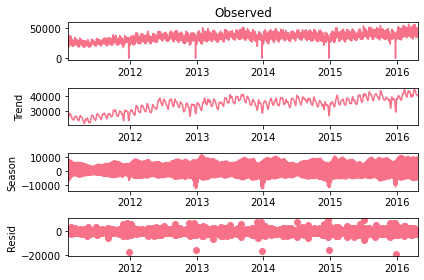

In [135]:
from statsmodels.tsa.seasonal import STL

stl = STL(stl_df, seasonal = 7)     # 7 shows weekly seasonality 
res = stl.fit()
plt.figure(figsize=(25,10))
fig = res.plot()
plt.show()

* Trend curve is pretty periodic and follows an increasing trend
* The season curve is almost similar for all the years.
* The residuals are also do not change much and  showing same periods  over the time.

In [136]:
del stl_df

### 4.8 Gathering more information on Weekly and monthly seasonality


In [137]:
# https://www.kaggle.com/arjunsehajpal/m5-forecasting-initialeda
sales_train_df['day_week'] = sales_train_df['date'].dt.weekday
sales_train_df['month']= sales_train_df['date'].dt.month
sales_train_df['year'] = sales_train_df['date'].dt.year

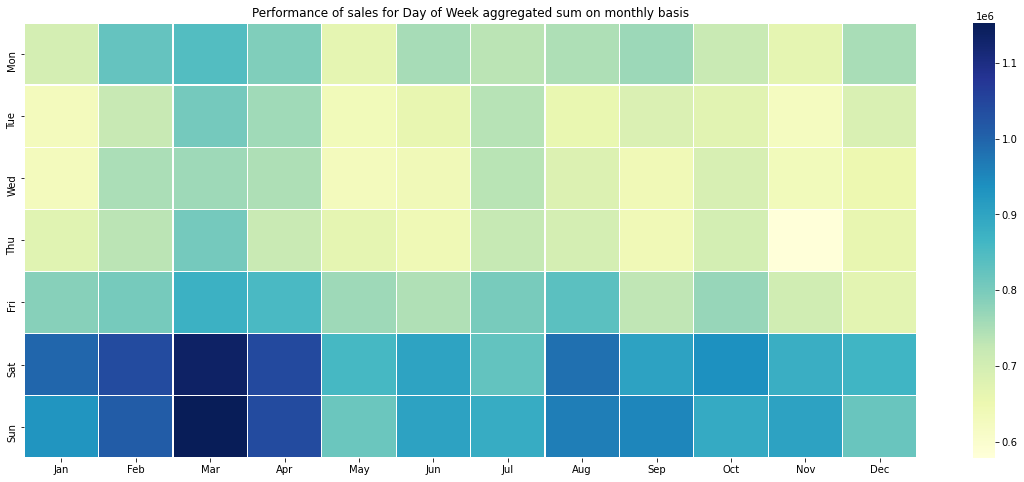

In [138]:
week_month_combination = sales_train_df.pivot_table(index = "day_week",columns = "month",values = "unit_sales",aggfunc = "sum")

week_month_combination.columns = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
week_month_combination.index = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
plt.figure(figsize=(20,8))
sns.heatmap(week_month_combination, linewidth = 0.3, cmap="YlGnBu")
plt.title("Performance of sales for Day of Week aggregated sum on monthly basis")
plt.show()

*  The sales on saturday and sunday (Weekends) are very high compared to that if the weekdays.
* The highest sales are recorded in Feb,March and April weekends.


In [139]:
del week_month_combination

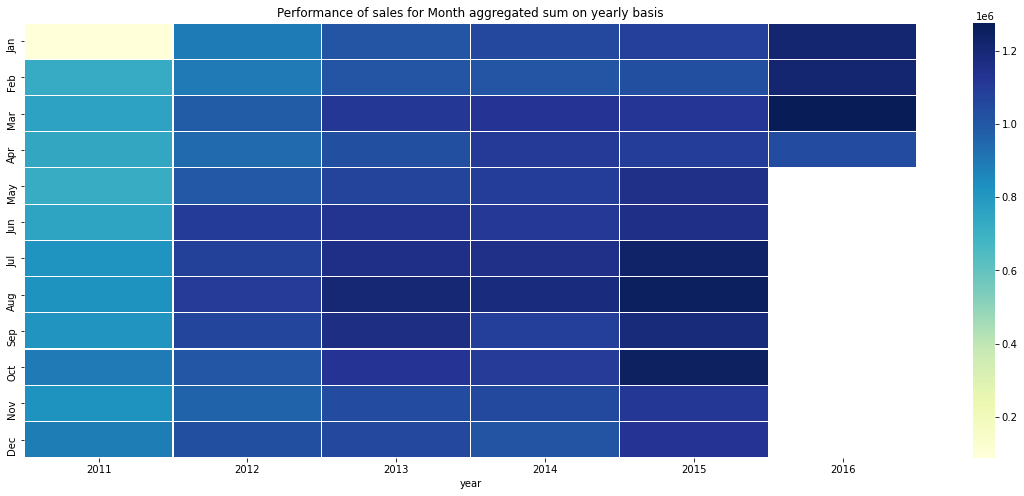

In [140]:
year_month_combination = sales_train_df.pivot_table(index = "month",columns = "year",values = "unit_sales",aggfunc = "sum")

year_month_combination.index = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
plt.figure(figsize=(20,8))
sns.heatmap(year_month_combination, linewidth = 0.2, cmap="YlGnBu")
plt.title("Performance of sales for Month aggregated sum on yearly basis")
plt.show()

* Sales have increased year wise.
* The given data is only till April 2016.So, after that the heatmap is empty.
* The mid months Jun,July,Aug and Sept have relatively higher sales.

In [141]:
del year_month_combination

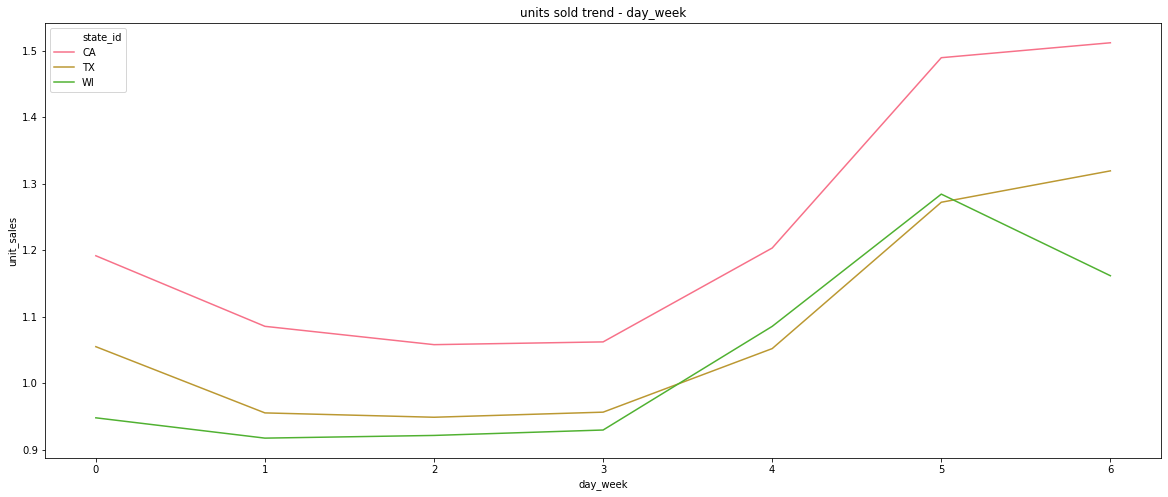

In [142]:
weekly_trend = sales_train_df.groupby(['day_week', 'state_id']).agg({'unit_sales': 'mean'}).reset_index()
plt.figure(figsize=(20,8))
sns.lineplot(x = 'day_week', y = "unit_sales", hue = "state_id", data = weekly_trend)
plt.title("units sold trend - day_week")
plt.show()

* The weekly pattern is similar for all the states here decreasing till the mid-week and then increasing till the weekend.
* Hghest being the CA state, where as TX ans WI are almost coinciding.

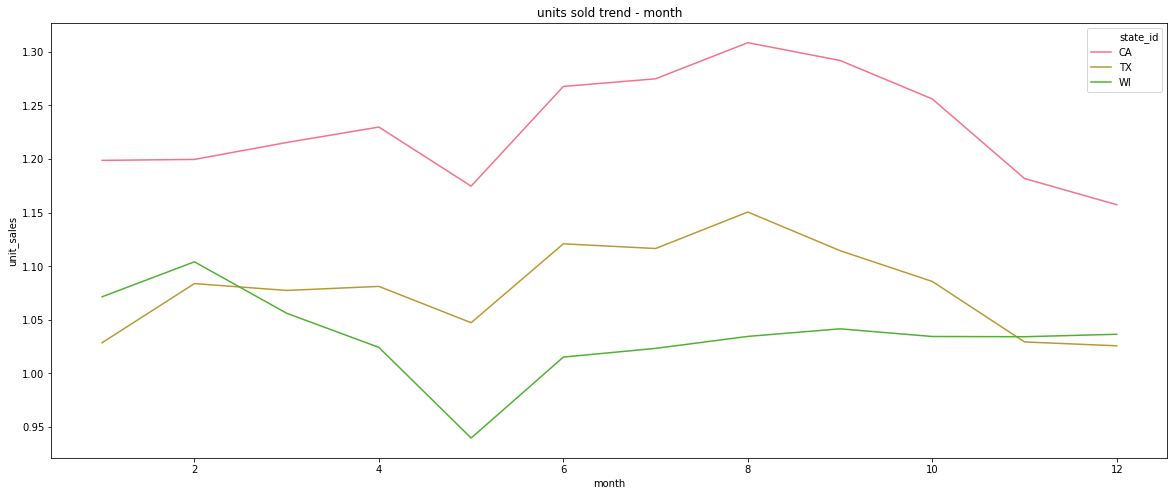

In [143]:
monthly_trend = sales_train_df.groupby(['month', 'state_id']).agg({'unit_sales': 'mean'}).reset_index()
plt.figure(figsize=(20,8))
sns.lineplot(x = 'month', y = "unit_sales", hue = "state_id", data = monthly_trend)
plt.title("units sold trend - month")
plt.show()

* The lowest sales in the 5th month and highest in 8th month.
* There is a dip in the sales of Jun month followed by rise till the August month and then a drop again.

In [144]:
del weekly_trend
del monthly_trend

### 5. Sell_Price and Calendar Events
This section explores the additional datasets provided to us, i.e. calendar and prices dataset. 
The prices dataset contains the information about the price of the products sold per store and week
The calender dataset contains information about the dates on which the products are sold.

### 5.1 Calendar Events

In [145]:
event1_bool = []   # boolean list. Captures whether an event exist or not
for i in range(0, len(calendar)):
    if calendar["event_name_1"].iloc[i] == calendar["event_name_1"].iloc[i]:
        event1_bool.append("True")
    else:
        event1_bool.append("False")
        
# inserting the above list in calendar_df
calendar.insert(loc = 9, column = "event_bool_1", value = event1_bool)

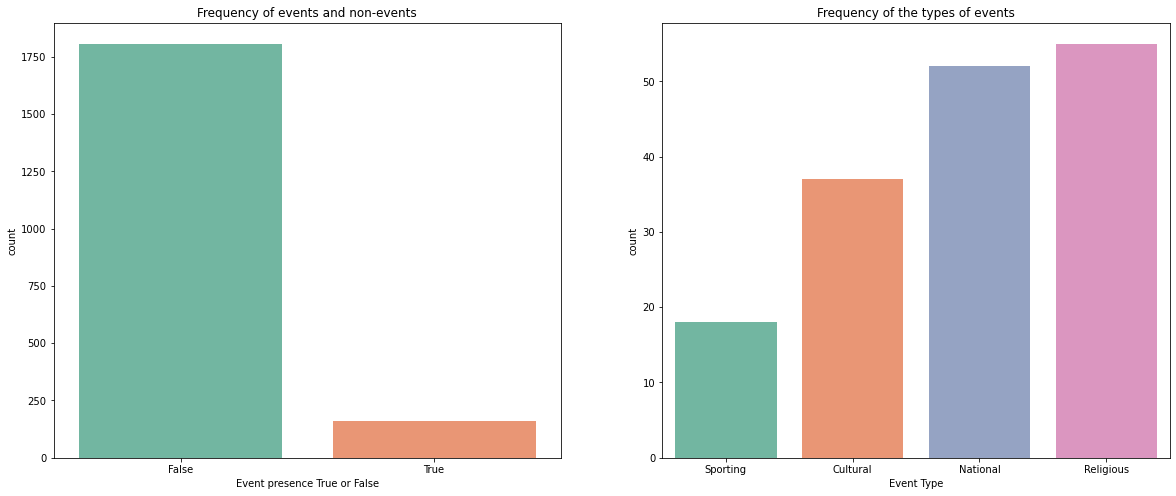

In [146]:
# plot distribution of event days
plt.figure(figsize=(20,8))
plt.subplot(1, 2, 1)
sns.countplot(calendar["event_bool_1"], palette = "Set2")
plt.title("Frequency of events and non-events")
plt.xlabel("Event presence True or False")

plt.subplot(1, 2, 2)
sns.countplot(calendar["event_type_1"], palette = "Set2")
plt.title("Frequency of the types of events")
plt.xlabel("Event Type")

plt.show()

* The total number of events are very less around 200 in total 1913 days.
* The events are of 4 types with Religious being the highest and Sporting being the lowest.

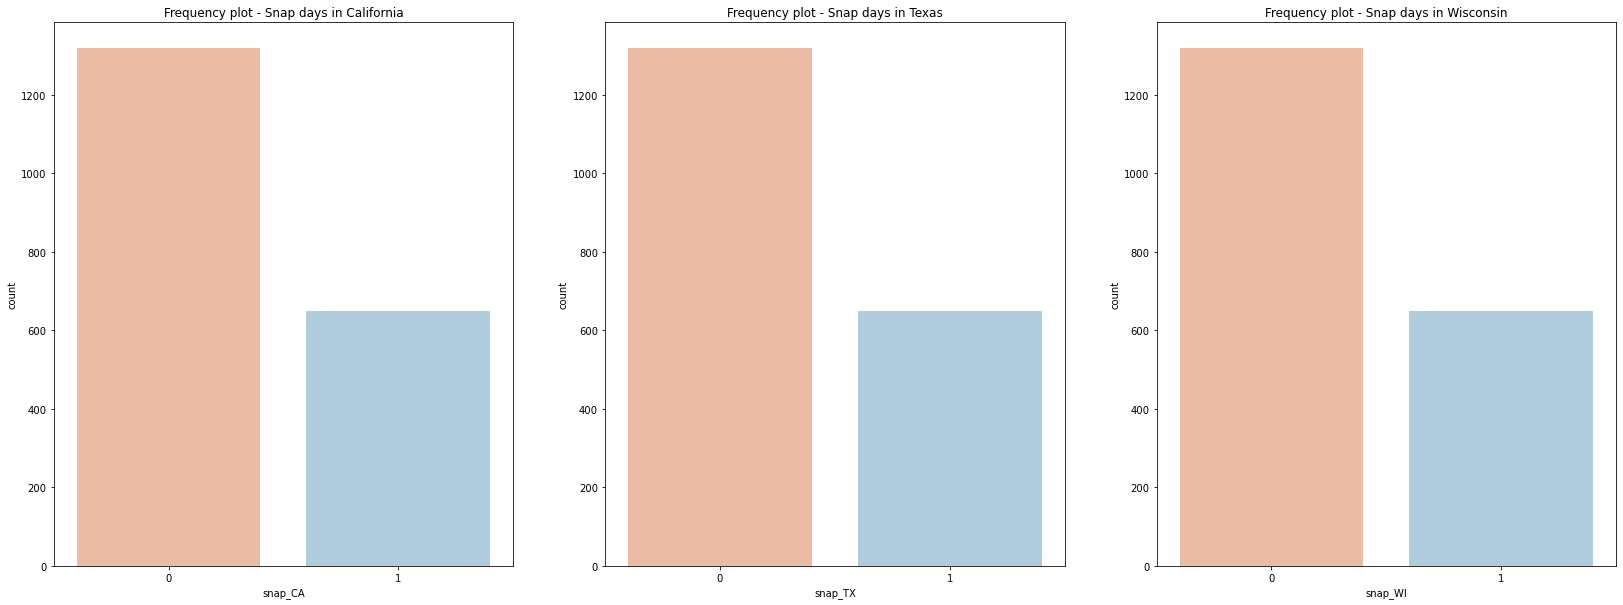

In [147]:
# plot distribution of snap days across three states
plt.figure(figsize=(28,10))
plt.subplot(1, 3, 1)
sns.countplot(x = calendar["snap_CA"], palette = "RdBu")
plt.title("Frequency plot - Snap days in California")

plt.subplot(1, 3, 2)
sns.countplot(x = calendar["snap_TX"], palette = "RdBu")
plt.title("Frequency plot - Snap days in Texas")

plt.subplot(1, 3, 3)
sns.countplot(x = calendar["snap_WI"], palette = "RdBu")
plt.title("Frequency plot - Snap days in Wisconsin")

plt.show()

* This shows that total number of SNAP days are same for all the states.
* To be clear, we need to know those days of the month in every state.


In [148]:
# https://www.kaggle.com/one1111/m5-analysis-by-departments-and-stores-eda
def calendar_dates_extension(data,year):
    first_week = datetime(year, 1, 1) - pd.to_timedelta(datetime(year, 1, 1).weekday(),unit="d")
    first_nan_period = pd.date_range(first_week, data.first_valid_index(),closed="left")
    data = data.append(pd.DataFrame(index=first_nan_period))
    
    last_week = datetime(year, 12, 31) + pd.to_timedelta(6-datetime(year, 12, 31).weekday(),unit="d")
    last_nan_period = pd.date_range(data.last_valid_index(), last_week,closed="right")
    data = data.append(pd.DataFrame(index=(last_nan_period))).sort_index()
    
    num_weeks = len(data)//7

    data = data.values.reshape(num_weeks,7).T
    return data

In [149]:
def border_polygon(ax,year, data, cmap):
    ax.tick_params('x', length=0, labelsize="medium", which='major')
    ax.tick_params('y', length=0, labelsize="x-small", which='major')

    ax.pcolormesh(data, edgecolors='grey', linewidth=0.2,cmap=cmap,vmin=-1, vmax=1)
    # Month borders
    xticks, labels = [], []
    start = datetime(year, 1, 1).weekday()
    for month in range(1, 13):
        first = datetime(year, month, 1)
        last = first + relativedelta(months=1, days=-1)

        y0 = first.weekday()
        y1 = last.weekday()
        x0 = (int(first.strftime("%j")) + start - 1) // 7
        x1 = (int(last.strftime("%j")) + start - 1) // 7

        P = [(x0, y0), (x0, 7), (x1, 7),(x1, y1 + 1), (x1 + 1, y1 + 1),
             (x1 + 1, 0),(x0 + 1, 0), (x0 + 1, y0)]
        xticks.append(x0 + (x1 - x0 + 1) / 2)
        labels.append(first.strftime("%b"))
        poly = Polygon(P, edgecolor="r", facecolor="None",
                       linewidth=1.5, zorder=20, clip_on=False)
        ax.add_artist(poly)

    ax.set_xticks(xticks)
    ax.set_xticklabels(labels)
    ax.set_yticks(0.5 + np.arange(7))
    ax.set_yticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])


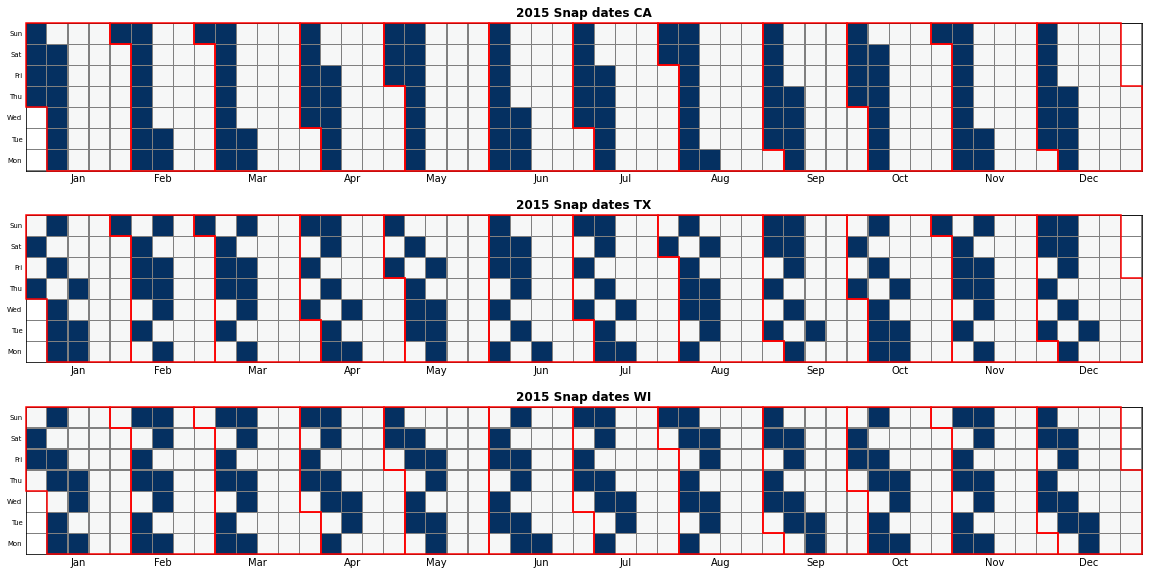

In [150]:
year= 2015
cal_tmp = calendar.loc[calendar["year"]==year,["snap_CA","date"]].set_index("date")
array_cal = calendar_dates_extension(cal_tmp,year)
fig = plt.figure(figsize=(20, 10))
ax = plt.subplot(311, xlim=[0,array_cal.shape[1]], ylim=[0,7], frameon=True, aspect=1)
border_polygon(ax, year, array_cal,"RdBu")
ax.set_title("{} Snap dates CA".format(year), weight="semibold")

cal_tmp = calendar.loc[calendar["year"]==year,["snap_TX","date"]].set_index("date")
array_cal = calendar_dates_extension(cal_tmp,year)
ax = plt.subplot(312, xlim=[0,array_cal.shape[1]], ylim=[0,7], frameon=True, aspect=1)
border_polygon(ax, year, array_cal,"RdBu")
ax.set_title("{} Snap dates TX".format(year), weight="semibold")

cal_tmp = calendar.loc[calendar["year"]==year,["snap_WI","date"]].set_index("date")
array_cal = calendar_dates_extension(cal_tmp,year)
ax = plt.subplot(313, xlim=[0,array_cal.shape[1]], ylim=[0,7], frameon=True, aspect=1)
border_polygon(ax, year, array_cal,"RdBu")
ax.set_title("{} Snap dates WI".format(year), weight="semibold")
plt.show()

* SNAP has exactly 10 days in every month for all the states.
* These occur on same dates for each month in every state.
* CA has SNAP days on the first 10 days continuously.
* TX has SNAP on 1,3,5,6,7,9,11,12,13,15 days.
* WI has SNAP on 2,3,5,6,8,9,11,12,14,15 days.
* A point to notice is SNAP days are in the first 15 days of the month for all the states.
* The above plot conveys us that the snap days are usually occuring on same dates throughout the year.

In [151]:
del cal_tmp

### 5.2 Sales_prices

In [152]:
# creating a few additional columns to aid in analysis below

sell_prices["state"] = sell_prices["store_id"].str[:2]
sell_prices["cat_id"] = sell_prices["item_id"].str[:-4]
sell_prices

,store_id,item_id,wm_yr_wk,sell_price,state,cat_id
0,CA_1,HOBBIES_1_001,11325,9.578125,CA,HOBBIES_1
1,CA_1,HOBBIES_1_001,11326,9.578125,CA,HOBBIES_1
2,CA_1,HOBBIES_1_001,11327,8.257812,CA,HOBBIES_1
3,CA_1,HOBBIES_1_001,11328,8.257812,CA,HOBBIES_1
4,CA_1,HOBBIES_1_001,11329,8.257812,CA,HOBBIES_1
...,...,...,...,...,...,...
6841116,WI_3,FOODS_3_827,11617,1.000000,WI,FOODS_3
6841117,WI_3,FOODS_3_827,11618,1.000000,WI,FOODS_3
6841118,WI_3,FOODS_3_827,11619,1.000000,WI,FOODS_3
6841119,WI_3,FOODS_3_827,11620,1.000000,WI,FOODS_3


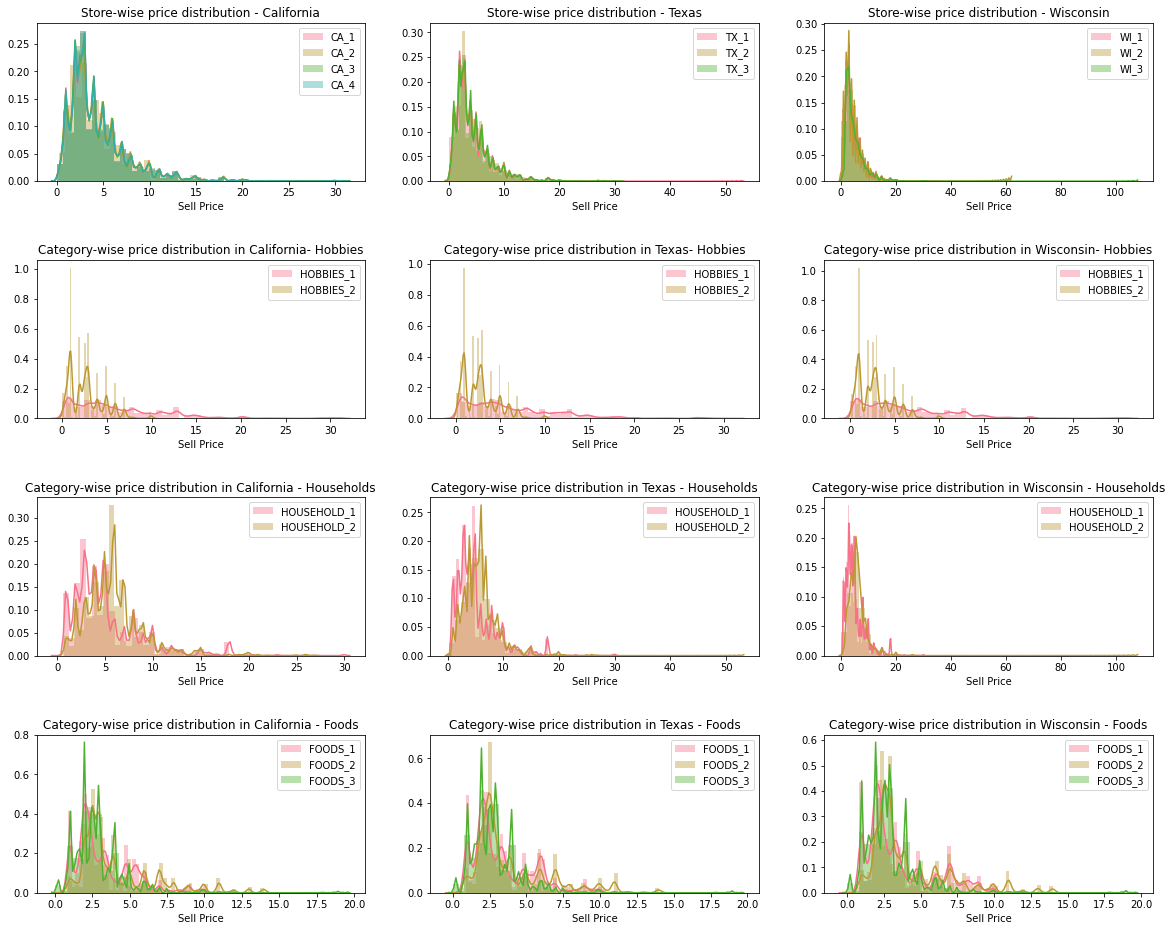

In [153]:
# plotting the distribution plot of various stores in a state

plt.figure(figsize = (20, 16))
plt.subplots_adjust(hspace = 0.5)

plt.subplot(4, 3, 1)
for i in ["CA_1", "CA_2", "CA_3", "CA_4"]:
    sns.distplot(sell_prices[sell_prices["store_id"] == i]["sell_price"], label = i)
    plt.legend()
    plt.xlabel("Sell Price")
    plt.title("Store-wise price distribution - California")

plt.subplot(4, 3, 2)
for i in ["TX_1", "TX_2", "TX_3"]:
    sns.distplot(sell_prices[sell_prices["store_id"] == i]["sell_price"], label = i)
    plt.legend()
    plt.xlabel("Sell Price")
    plt.title("Store-wise price distribution - Texas")

plt.subplot(4, 3, 3)
for i in ["WI_1", "WI_2", "WI_3"]:
    sns.distplot(sell_prices[sell_prices["store_id"] == i]["sell_price"], label = i)
    plt.legend()
    plt.xlabel("Sell Price")
    plt.title("Store-wise price distribution - Wisconsin")
    
plt.subplot(4, 3, 4)
for i in ["HOBBIES_1", "HOBBIES_2"]:
    sns.distplot(sell_prices[(sell_prices["cat_id"] == i) & (sell_prices["state"] == "CA")]["sell_price"], label = i)
    plt.legend()
    plt.xlabel("Sell Price")
    plt.title("Category-wise price distribution in California- Hobbies")
    
plt.subplot(4, 3, 5)
for i in ["HOBBIES_1", "HOBBIES_2"]:
    sns.distplot(sell_prices[(sell_prices["cat_id"] == i) & (sell_prices["state"] == "TX")]["sell_price"], label = i)
    plt.legend()
    plt.xlabel("Sell Price")
    plt.title("Category-wise price distribution in Texas- Hobbies")
    
plt.subplot(4, 3, 6)
for i in ["HOBBIES_1", "HOBBIES_2"]:
    sns.distplot(sell_prices[(sell_prices["cat_id"] == i) & (sell_prices["state"] == "WI")]["sell_price"], label = i)
    plt.legend()
    plt.xlabel("Sell Price")
    plt.title("Category-wise price distribution in Wisconsin- Hobbies")

plt.subplot(4, 3, 7)
for i in ["HOUSEHOLD_1", "HOUSEHOLD_2"]:
    sns.distplot(sell_prices[(sell_prices["cat_id"] == i) & (sell_prices["state"] == "CA")]["sell_price"], label = i)
    plt.legend()
    plt.xlabel("Sell Price")
    plt.title("Category-wise price distribution in California - Households")

plt.subplot(4, 3, 8)
for i in ["HOUSEHOLD_1", "HOUSEHOLD_2"]:
    sns.distplot(sell_prices[(sell_prices["cat_id"] == i) & (sell_prices["state"] == "TX")]["sell_price"], label = i)
    plt.legend()
    plt.xlabel("Sell Price")
    plt.title("Category-wise price distribution in Texas - Households")  
    
plt.subplot(4, 3, 9)
for i in ["HOUSEHOLD_1", "HOUSEHOLD_2"]:
    sns.distplot(sell_prices[(sell_prices["cat_id"] == i) & (sell_prices["state"] == "WI")]["sell_price"], label = i)
    plt.legend()
    plt.xlabel("Sell Price")
    plt.title("Category-wise price distribution in Wisconsin - Households")

plt.subplot(4, 3, 10)
for i in ["FOODS_1", "FOODS_2", "FOODS_3"]:
    sns.distplot(sell_prices[(sell_prices["cat_id"] == i) & (sell_prices["state"] == "CA")]["sell_price"], label = i)
    plt.legend()
    plt.xlabel("Sell Price")
    plt.title("Category-wise price distribution in California - Foods")
    
plt.subplot(4, 3, 11)
for i in ["FOODS_1", "FOODS_2", "FOODS_3"]:
    sns.distplot(sell_prices[(sell_prices["cat_id"] == i) & (sell_prices["state"] == "TX")]["sell_price"], label = i)
    plt.legend()
    plt.xlabel("Sell Price")
    plt.title("Category-wise price distribution in Texas - Foods")
    
plt.subplot(4, 3, 12)
for i in ["FOODS_1", "FOODS_2", "FOODS_3"]:
    sns.distplot(sell_prices[(sell_prices["cat_id"] == i) & (sell_prices["state"] == "WI")]["sell_price"], label = i)
    plt.legend()
    plt.xlabel("Sell Price")
    plt.title("Category-wise price distribution in Wisconsin - Foods")
    

* The probability distribution of price is almost identical in all the three states - CA, TX and WI. The difference is the tail of WI is more compared to TX and TX tail is more compared to CA.
* The distribution of price for HOBBIES_1 and HOBBIES_2 looks same for all the three states.
* The food price distribution have peaks occuring at the same place in the graph.This could be due to fact that food prices are normally similar across states.
* Irrespective of the Categories almost all the states have the same price distribution. 
* The tail of Wisconsin is more because of the HOUSEHOLD_2 prices as we can see from 9th plot.



## 6. Sample_submission

In [154]:
# Helper functions to find the quartile,state and category from the ids in the submission file.


def find_quartile_value(l):
    
    if "0.005" in l:
        return 0.005
    if "0.025" in l:
        return 0.025
    if "0.165" in l:
        return 0.165
    if "0.25" in l:
        return 0.25
    if "0.5" in l:
        return 0.5
    if "0.75" in l:
        return 0.75
    if "0.835" in l:
        return 0.835
    if "0.975" in l:
        return 0.975
    if "0.995" in l:
        return 0.995
    else:
        return 0
    
def find_state(l):
    if "CA" in l:
        return "CA"
    if "TX" in l:
        return "TX"
    if "WI" in l:
        return "WI"
    else:
        return "Unknown"
    
def find_category(l):
    if "FOODS" in l:
        return "foods"
    if "HOBBIES" in l:
        return "hobbies"
    if "HOUSEHOLD" in l:
        return "household"
    else:
        return "Unknown"

In [155]:
sample_submission_df = pd.DataFrame(sample_submission.id, columns=["id"])
sample_submission_df.loc[:, "lb_type"] = np.where(sample_submission.id.str.contains("validation"), "validation", "evaluation")
sample_submission_df.loc[:, "q"] = sample_submission.id.apply(lambda l: find_quartile_value(l))   # finding quartile value  for each id
sample_submission_df.loc[:, "state"] = sample_submission.id.apply(lambda l: find_state(l))        # finding state for each id
sample_submission_df.loc[:, "category"] = sample_submission.id.apply(lambda l: find_category(l))  # finding category foreach id

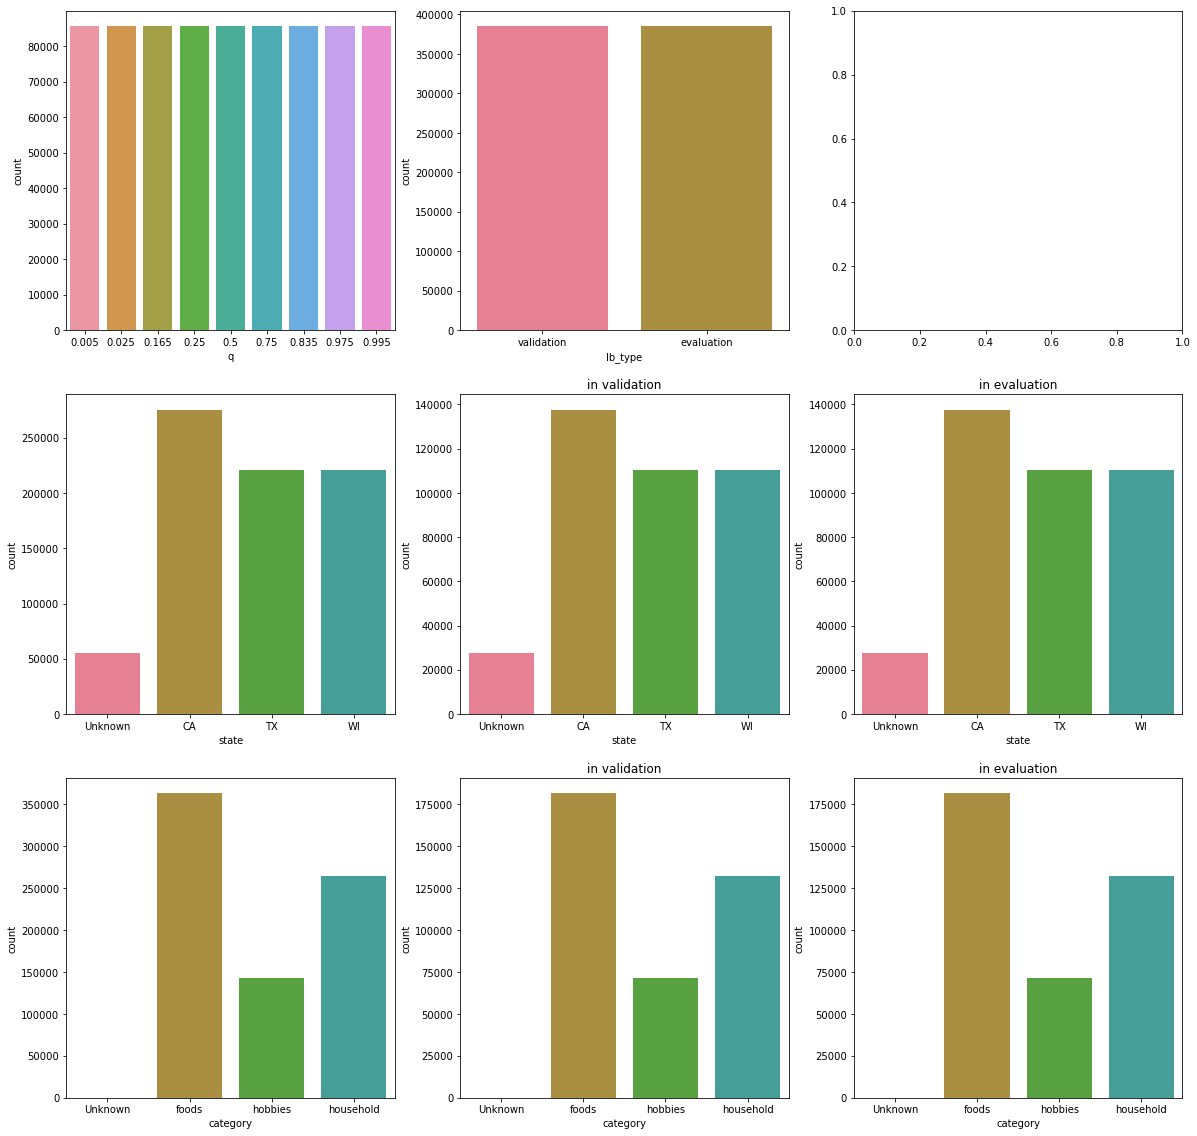

In [156]:
sns.set_palette("husl")

fig, ax = plt.subplots(3,3,figsize=(20,20))
sns.countplot(sample_submission_df.q, ax=ax[0,0]);
sns.countplot(sample_submission_df.lb_type, ax=ax[0,1]);   # lbtype is leader board type validation or evaluation
sns.countplot(sample_submission_df.state, ax=ax[1,0]);
sns.countplot(sample_submission_df.loc[sample_submission_df.lb_type=="validation"].state, ax=ax[1,1]);
sns.countplot(sample_submission_df.loc[sample_submission_df.lb_type=="evaluation"].state, ax=ax[1,2]);
sns.countplot(sample_submission_df.category, ax=ax[2,0]);
sns.countplot(sample_submission_df.loc[sample_submission_df.lb_type=="validation"].category, ax=ax[2,1]);
sns.countplot(sample_submission_df.loc[sample_submission_df.lb_type=="evaluation"].category, ax=ax[2,2]);
for n in range(1,3):
    ax[n,1].set_title("in validation")
    ax[n,2].set_title("in evaluation")

* Each quartile q has exactily $2*42840 = 85680$ ids. The total number of all 12 level timeseries is 42840, each for validation and evaluation.
* The lb_type will be $85680*9 = 771120$ , half for validation and half for evaluation.
* Every id has a particular state name and there are certain ids which do not represent any state which are unknown.
* The food category being the highest and hobbies the lowest.


## 7. Merging Calender and Sales_train data

In [157]:
# Making a temp dataframe with necessary information
temp_df = sales_train_df.groupby(["date", "state_id"])[["unit_sales"]].sum()
temp_df = temp_df.reset_index()
temp_df = temp_df.merge(calendar[["date", "snap_CA", "snap_TX", "snap_WI"]], on="date")
temp_df

,date,state_id,unit_sales,snap_CA,snap_TX,snap_WI
0,2011-01-29,CA,14195,0,0,0
1,2011-01-29,TX,9438,0,0,0
2,2011-01-29,WI,8998,0,0,0
3,2011-01-30,CA,13805,0,0,0
4,2011-01-30,TX,9630,0,0,0
...,...,...,...,...,...,...
5734,2016-04-23,TX,12266,0,0,0
5735,2016-04-23,WI,14862,0,0,0
5736,2016-04-24,CA,23187,0,0,0
5737,2016-04-24,TX,12282,0,0,0


In [158]:
SNAP_CA = temp_df[temp_df['state_id']=='CA']
SNAP_TX = temp_df[temp_df['state_id']=='TX']
SNAP_WI = temp_df[temp_df['state_id']=='WI']
SNAP_CA_1 = SNAP_CA[temp_df['snap_CA']==1]
SNAP_CA_0 = SNAP_CA[temp_df['snap_CA']==0]
SNAP_TX_1 = SNAP_TX[temp_df['snap_TX']==1]
SNAP_TX_0 = SNAP_TX[temp_df['snap_TX']==0]
SNAP_WI_1 = SNAP_WI[temp_df['snap_WI']==1]
SNAP_WI_0 = SNAP_WI[temp_df['snap_WI']==0]

In [159]:
print('Minimum sales with SNAP is ' ,SNAP_CA_1['unit_sales'].min())
print('Minimum sales without SNAP is ',SNAP_CA_0['unit_sales'].min())

Minimum sales with SNAP is  9281
Minimum sales without SNAP is  5


Based on the minimum sales we can easily say that during a SNAP days, people tend to go to stores lot more than normal days.

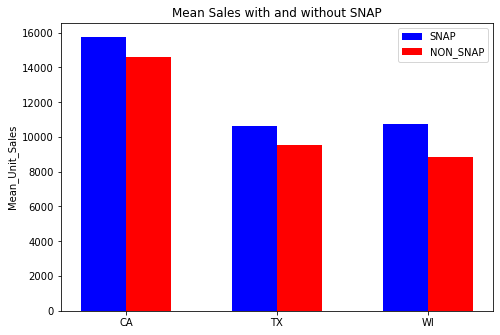

In [160]:
width = 0.3
Labels = ['CA','TX','WI']
x = np.arange(len(Labels))
Mean_SNAP_1 = [SNAP_CA_1['unit_sales'].mean(),SNAP_TX_1['unit_sales'].mean(),SNAP_WI_1['unit_sales'].mean()]
Mean_SNAP_0 = [SNAP_CA_0['unit_sales'].mean(),SNAP_TX_0['unit_sales'].mean(),SNAP_WI_0['unit_sales'].mean()]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(x-width/2,Mean_SNAP_1,width,color='b')
ax.bar(x+width/2,Mean_SNAP_0, width,color='r')
ax.set_ylabel('Mean_Unit_Sales')
ax.set_title('Mean Sales with and without SNAP')
ax.set_xticks(x)
ax.set_xticklabels(Labels)
ax.legend(labels=['SNAP', 'NON_SNAP'])
plt.show()

* Mean is relatively higher for SNAP days than NON-SNAP days.
* We can conclude people visit stores more on SNAP days for additional nutritional products compared to normal days.
* WI has more difference than other two states.


# Summary of EDA 

* Understanding the given sales_train_validation,calendar,sales_price and submission data files.
* Analysing each data file one by one by exploring each column in the data.
* Reducing the sales_train size of the data by 78%.
* Checking the time series seasonality of the over all aggregate of the sales.
* Checked the seasonality of aggregate sales of time series.
* From calendar,checked how events affected the sales.
* Weekends are the days that abundant of the sales happen.
* The prices of products on all the three different regions almost are same throughout.
* Checked the variation with respect to SNAP days with the sales aggregation.
